In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import requests
import os
import csv
import keras
import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy 

Using TensorFlow backend.


Pulls data from websites and stores them in csv files

In [2]:
def update_data():
    positive_cases_csv_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    req = requests.get(positive_cases_csv_URL)
    URL_content = req.content
    positive_cases_file = open("positive_cases.csv", "wb")
    positive_cases_file.write(URL_content)
    positive_cases_file.close()

This is purely for the sources of data that include data outside the UK as having international data would mean too much to parse through

In [3]:
def filter_data(filename):
    uk = list()
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile)
        for row in reader:
            if row[0] == "GBR" or row[0] == "iso_code":
                uk.append(row)
    
    with open(filename, 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(uk)  


Counts the number of days since the earliest data entry

In [4]:
def numberofdays(date_in_question):
    start_date = date(2020, 1, 31)
    dateq = date_in_question.split("-")
    cdate = date(int(dateq[0]), int(dateq[1]), int(dateq[2]))
    return (cdate - start_date).days

This will normalise all the data in a dataframe

In [5]:
def normalise_dataframe(df):
    for i in range(1, len(df.columns)):
        maxi = max(df.iloc[:,i])
        mini = min(df.iloc[:,i])
        for j in range(len(df.iloc[:,0])):
            df.iloc[j, i] = (df.iloc[j, i] - mini)/(maxi-mini)

This will only take columns in the data frame with no NaNs

In [6]:
def no_NaNs(df):
    data = []
    for column in df.columns:
        temp = [float(i) for i in df[column]]
        if np.isnan(np.sum(np.array(temp))):
            df.drop([column], inplace=True, axis=1)

This will only take columns that don't have a single repeating entry

In [7]:
def no_repeat(df):
    data = []
    for column in df.columns:
        if df[column].nunique() == 1:
            df.drop([column], inplace=True, axis=1)

This will create the input array for the Neural Network

In [8]:
def create_features(df, window_size, forecast):
    features = []
    labels = []
    i = window_size;
    while i < len(df.iloc[:, 0]) - forecast-1:
        window = df.iloc[i - window_size: i, 1:]
        window = np.array(window)
        window = window.flatten()
        labels.append(df.iloc[i + forecast, 0])
        features.append(window)
        i += 1
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [9]:
update_data() 

In [10]:
filter_data("positive_cases.csv")

Grabs the current working directory where the csv files are stored

In [11]:
working_dir = os.getcwd()

Reads the csv files into their respective dataframes

In [12]:
pos_cases_df = pd.read_csv(os.path.join(working_dir, "positive_cases.csv"))
pos_cases_df.drop(pos_cases_df.iloc[:, 0:3], inplace = True, axis=1)
dates = pos_cases_df["date"]
pos_cases_df.drop(["date"], inplace = True, axis=1)
pos_cases_df.drop(["tests_units"], inplace = True, axis=1)

In [13]:
no_NaNs(pos_cases_df)

In [14]:
no_repeat(pos_cases_df)

In [15]:
print((pos_cases_df.head()).to_markdown())

|    |   total_cases |   new_cases |   total_cases_per_million |   new_cases_per_million |
|---:|--------------:|------------:|--------------------------:|------------------------:|
|  0 |             2 |           2 |                     0.029 |                   0.029 |
|  1 |             2 |           0 |                     0.029 |                   0     |
|  2 |             2 |           0 |                     0.029 |                   0     |
|  3 |             8 |           6 |                     0.118 |                   0.088 |
|  4 |             8 |           0 |                     0.118 |                   0     |


Code just adds a column to the dataframe that counts the number of days since the earliest data entry

In [16]:
daysSince = []
for i in range(len(pos_cases_df)):
    daysSince.append(i)
pos_cases_df["daysSince"] = daysSince

In [17]:
print((pos_cases_df.head()).to_markdown())

|    |   total_cases |   new_cases |   total_cases_per_million |   new_cases_per_million |   daysSince |
|---:|--------------:|------------:|--------------------------:|------------------------:|------------:|
|  0 |             2 |           2 |                     0.029 |                   0.029 |           0 |
|  1 |             2 |           0 |                     0.029 |                   0     |           1 |
|  2 |             2 |           0 |                     0.029 |                   0     |           2 |
|  3 |             8 |           6 |                     0.118 |                   0.088 |           3 |
|  4 |             8 |           0 |                     0.118 |                   0     |           4 |


Here I make the feature and label matrices with a 7 day window and a 1 day forecast

In [18]:
window_size = 7
forecast = 1
features1, labels1 = create_features(pos_cases_df, window_size, forecast)

Splitting the feature and label matrices into training and testing by 8:2. I will split the training further down into 8:2 again for validation.

In [19]:
training_features1, testing_features1 = np.split(features1, [int(0.8*len(features1))])
training_labels1, testing_labels1 = np.split(labels1, [int(0.8*len(labels1))])

In [20]:
input_shape = training_features1.shape[1]

In [21]:
NN_model = Sequential()
# Input layer
NN_model.add(Dense(128, input_dim=input_shape, kernel_initializer="normal", activation="relu"))
# Hidden Layers
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
# Output layer 
NN_model.add(Dense(1, kernel_initializer="normal", activation="linear"))

NN_model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3712      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________


In [20]:
history1 = NN_model.fit(training_features1, training_labels1, epochs=500, validation_split=0.2)

Train on 261 samples, validate on 66 samples
Epoch 1/500
261/261 [==============================] - 0s 888us/step - loss: 250428.5345 - accuracy: 0.0000e+00 - val_loss: 1553346.3485 - val_accuracy: 0.0000e+00
Epoch 2/500
261/261 [==============================] - 0s 120us/step - loss: 229867.9078 - accuracy: 0.0000e+00 - val_loss: 1138850.6780 - val_accuracy: 0.0000e+00
Epoch 3/500
261/261 [==============================] - 0s 60us/step - loss: 119646.5588 - accuracy: 0.0000e+00 - val_loss: 887179.9811 - val_accuracy: 0.0000e+00
Epoch 4/500
261/261 [==============================] - 0s 120us/step - loss: 96479.3670 - accuracy: 0.0000e+00 - val_loss: 177836.5076 - val_accuracy: 0.0000e+00
Epoch 5/500
261/261 [==============================] - 0s 120us/step - loss: 58001.1678 - accuracy: 0.0000e+00 - val_loss: 120781.4773 - val_accuracy: 0.0000e+00
Epoch 6/500
261/261 [==============================] - 0s 85us/step - loss: 31806.1906 - accuracy: 0.0000e+00 - val_loss: 42505.5975 - val_ac

261/261 [==============================] - 0s 120us/step - loss: 2098.8510 - accuracy: 0.0077 - val_loss: 12704.2907 - val_accuracy: 0.0000e+00
Epoch 105/500
261/261 [==============================] - 0s 60us/step - loss: 2501.9112 - accuracy: 0.0115 - val_loss: 16845.4299 - val_accuracy: 0.0000e+00
Epoch 106/500
261/261 [==============================] - 0s 145us/step - loss: 1485.6267 - accuracy: 0.0115 - val_loss: 13127.3523 - val_accuracy: 0.0000e+00
Epoch 107/500
261/261 [==============================] - 0s 60us/step - loss: 1392.3556 - accuracy: 0.0192 - val_loss: 9047.4669 - val_accuracy: 0.0000e+00
Epoch 108/500
261/261 [==============================] - 0s 120us/step - loss: 2665.5764 - accuracy: 0.0192 - val_loss: 8344.8977 - val_accuracy: 0.0000e+00
Epoch 109/500
261/261 [==============================] - 0s 60us/step - loss: 2297.0923 - accuracy: 0.0038 - val_loss: 7758.2377 - val_accuracy: 0.0000e+00
Epoch 110/500
261/261 [==============================] - 0s 85us/step - 

261/261 [==============================] - 0s 85us/step - loss: 6205.9133 - accuracy: 0.0192 - val_loss: 33810.7481 - val_accuracy: 0.0000e+00
Epoch 157/500
261/261 [==============================] - 0s 120us/step - loss: 5214.2052 - accuracy: 0.0115 - val_loss: 42720.8182 - val_accuracy: 0.0000e+00
Epoch 158/500
261/261 [==============================] - 0s 120us/step - loss: 3114.6331 - accuracy: 0.0038 - val_loss: 21365.3996 - val_accuracy: 0.0000e+00
Epoch 159/500
261/261 [==============================] - 0s 85us/step - loss: 2464.7165 - accuracy: 0.0192 - val_loss: 35942.8826 - val_accuracy: 0.0000e+00
Epoch 160/500
261/261 [==============================] - 0s 60us/step - loss: 2581.8911 - accuracy: 0.0153 - val_loss: 13032.7178 - val_accuracy: 0.0000e+00
Epoch 161/500
261/261 [==============================] - 0s 60us/step - loss: 1723.1325 - accuracy: 0.0077 - val_loss: 6538.0966 - val_accuracy: 0.0000e+00
Epoch 162/500
261/261 [==============================] - 0s 120us/step 

261/261 [==============================] - 0s 89us/step - loss: 5586.8667 - accuracy: 0.0153 - val_loss: 34371.5795 - val_accuracy: 0.0000e+00
Epoch 209/500
261/261 [==============================] - 0s 60us/step - loss: 4866.4736 - accuracy: 0.0077 - val_loss: 23815.6080 - val_accuracy: 0.0000e+00
Epoch 210/500
261/261 [==============================] - 0s 120us/step - loss: 2750.5042 - accuracy: 0.0115 - val_loss: 52573.1780 - val_accuracy: 0.0000e+00
Epoch 211/500
261/261 [==============================] - 0s 120us/step - loss: 6807.1546 - accuracy: 0.0115 - val_loss: 74135.3996 - val_accuracy: 0.0000e+00
Epoch 212/500
261/261 [==============================] - 0s 59us/step - loss: 7064.3384 - accuracy: 0.0153 - val_loss: 67880.8939 - val_accuracy: 0.0000e+00
Epoch 213/500
261/261 [==============================] - 0s 60us/step - loss: 5404.9390 - accuracy: 0.0153 - val_loss: 9399.8826 - val_accuracy: 0.0000e+00
Epoch 214/500
261/261 [==============================] - 0s 120us/step 

261/261 [==============================] - 0s 145us/step - loss: 1897.5013 - accuracy: 0.0230 - val_loss: 7782.3475 - val_accuracy: 0.0000e+00
Epoch 313/500
261/261 [==============================] - 0s 60us/step - loss: 2441.0759 - accuracy: 0.0268 - val_loss: 10667.8835 - val_accuracy: 0.0000e+00
Epoch 314/500
261/261 [==============================] - 0s 120us/step - loss: 2452.5288 - accuracy: 0.0153 - val_loss: 15166.6525 - val_accuracy: 0.0000e+00
Epoch 315/500
261/261 [==============================] - 0s 120us/step - loss: 4875.7519 - accuracy: 0.0077 - val_loss: 63249.9886 - val_accuracy: 0.0000e+00
Epoch 316/500
261/261 [==============================] - 0s 85us/step - loss: 6611.6276 - accuracy: 0.0307 - val_loss: 17705.0663 - val_accuracy: 0.0000e+00
Epoch 317/500
261/261 [==============================] - 0s 60us/step - loss: 1596.8021 - accuracy: 0.0038 - val_loss: 21280.7235 - val_accuracy: 0.0000e+00
Epoch 318/500
261/261 [==============================] - 0s 60us/step 

261/261 [==============================] - 0s 96us/step - loss: 12535.2261 - accuracy: 0.0038 - val_loss: 89824.8068 - val_accuracy: 0.0000e+00
Epoch 417/500
261/261 [==============================] - 0s 92us/step - loss: 6482.2158 - accuracy: 0.0115 - val_loss: 30282.5019 - val_accuracy: 0.0000e+00
Epoch 418/500
261/261 [==============================] - 0s 96us/step - loss: 6233.6863 - accuracy: 0.0153 - val_loss: 47861.7292 - val_accuracy: 0.0000e+00
Epoch 419/500
261/261 [==============================] - 0s 96us/step - loss: 3418.0284 - accuracy: 0.0268 - val_loss: 8482.3968 - val_accuracy: 0.0000e+00
Epoch 420/500
261/261 [==============================] - 0s 92us/step - loss: 2387.0843 - accuracy: 0.0077 - val_loss: 6663.8911 - val_accuracy: 0.0000e+00
Epoch 421/500
261/261 [==============================] - 0s 92us/step - loss: 4483.3617 - accuracy: 0.0230 - val_loss: 39259.3220 - val_accuracy: 0.0000e+00
Epoch 422/500
261/261 [==============================] - 0s 100us/step - 

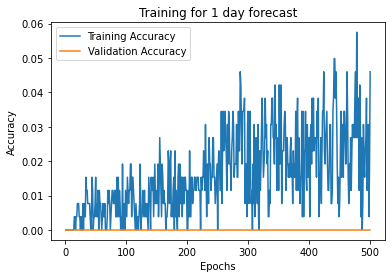

In [22]:
epochs = range(1, len(history1.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history1.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training for 1 day forecast")
plt.legend()
plt.show()

In [23]:
x = [i for i in range(int(testing_features1[0,-1]+1), int(testing_features1[-1,-1]+2))]
y = testing_labels1
x_pred = testing_features1
y_pred = NN_model.predict(x_pred)
err1 = np.abs(y - y_pred)
acc1 = np.ones(len(y)) - np.divide(err1, y)
acc_bar1 = np.mean(acc1)
rms1 = np.sqrt(np.mean((err1)**2))
print("Average accuracy:", acc_bar1)
print("RMS:", rms1)

Average accuracy: 0.8485905486581791
RMS: 705828.519894445


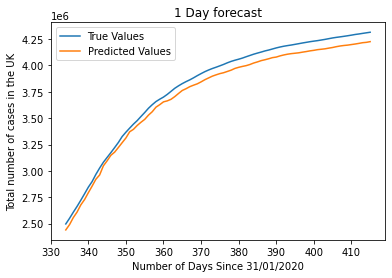

In [25]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Number of Days Since 31/01/2020")
plt.ylabel("Total number of cases in the UK")
plt.title("1 Day forecast")
plt.legend()
plt.show()

Here I make a new feature and label matrix with a 7 day window and a 2 day forecast

In [70]:
window_size = 7
forecast = 2
features2, labels2 = create_features(pos_cases_df, window_size, forecast)

I split the matrices down into training and testing using a 8:2 splitting

In [71]:
training_features2, testing_features2 = np.split(features2, [int(0.8*len(features2))])
training_labels2, testing_labels2 = np.split(labels2, [int(0.8*len(labels2))])

The model has to be trained again with this new data

In [72]:
history2 = NN_model.fit(training_features2, training_labels2, epochs=500, validation_split=0.2)

Train on 260 samples, validate on 66 samples
Epoch 1/500
260/260 [==============================] - 0s 132us/step - loss: 22516.2993 - accuracy: 0.0000e+00 - val_loss: 337713.1610 - val_accuracy: 0.0000e+00
Epoch 2/500
260/260 [==============================] - 0s 119us/step - loss: 10311.8476 - accuracy: 0.0000e+00 - val_loss: 337434.7689 - val_accuracy: 0.0000e+00
Epoch 3/500
260/260 [==============================] - 0s 131us/step - loss: 8841.1386 - accuracy: 0.0000e+00 - val_loss: 221852.4205 - val_accuracy: 0.0000e+00
Epoch 4/500
260/260 [==============================] - 0s 127us/step - loss: 5956.3347 - accuracy: 0.0000e+00 - val_loss: 235678.1837 - val_accuracy: 0.0000e+00
Epoch 5/500
260/260 [==============================] - 0s 108us/step - loss: 3910.7756 - accuracy: 0.0000e+00 - val_loss: 213225.1667 - val_accuracy: 0.0000e+00
Epoch 6/500
260/260 [==============================] - 0s 100us/step - loss: 4212.4659 - accuracy: 0.0038 - val_loss: 222645.9924 - val_accuracy: 0.

Epoch 52/500
260/260 [==============================] - 0s 60us/step - loss: 3274.7907 - accuracy: 0.0038 - val_loss: 162318.1591 - val_accuracy: 0.0000e+00
Epoch 53/500
260/260 [==============================] - 0s 145us/step - loss: 2378.2172 - accuracy: 0.0000e+00 - val_loss: 125575.6970 - val_accuracy: 0.0000e+00
Epoch 54/500
260/260 [==============================] - 0s 60us/step - loss: 3134.1097 - accuracy: 0.0038 - val_loss: 167737.1364 - val_accuracy: 0.0000e+00
Epoch 55/500
260/260 [==============================] - 0s 60us/step - loss: 2256.0464 - accuracy: 0.0000e+00 - val_loss: 145019.8466 - val_accuracy: 0.0000e+00
Epoch 56/500
260/260 [==============================] - 0s 120us/step - loss: 2339.6047 - accuracy: 0.0038 - val_loss: 135353.4621 - val_accuracy: 0.0000e+00
Epoch 57/500
260/260 [==============================] - 0s 85us/step - loss: 2771.3226 - accuracy: 0.0000e+00 - val_loss: 171037.8864 - val_accuracy: 0.0000e+00
Epoch 58/500
260/260 [======================

260/260 [==============================] - 0s 100us/step - loss: 2085.3105 - accuracy: 0.0038 - val_loss: 128527.6780 - val_accuracy: 0.0000e+00
Epoch 104/500
260/260 [==============================] - 0s 52us/step - loss: 1517.9561 - accuracy: 0.0038 - val_loss: 147190.4905 - val_accuracy: 0.0000e+00
Epoch 105/500
260/260 [==============================] - 0s 120us/step - loss: 1280.1049 - accuracy: 0.0000e+00 - val_loss: 136520.9583 - val_accuracy: 0.0000e+00
Epoch 106/500
260/260 [==============================] - 0s 120us/step - loss: 1267.4950 - accuracy: 0.0000e+00 - val_loss: 146106.6856 - val_accuracy: 0.0000e+00
Epoch 107/500
260/260 [==============================] - 0s 110us/step - loss: 1654.0650 - accuracy: 0.0000e+00 - val_loss: 135250.1288 - val_accuracy: 0.0000e+00
Epoch 108/500
260/260 [==============================] - 0s 120us/step - loss: 1629.8143 - accuracy: 0.0000e+00 - val_loss: 130159.9394 - val_accuracy: 0.0000e+00
Epoch 109/500
260/260 [======================

Epoch 205/500
260/260 [==============================] - ETA: 0s - loss: 1817.8276 - accuracy: 0.0000e+0 - 0s 60us/step - loss: 2118.8337 - accuracy: 0.0038 - val_loss: 126142.0114 - val_accuracy: 0.0000e+00
Epoch 206/500
260/260 [==============================] - 0s 60us/step - loss: 1607.3883 - accuracy: 0.0000e+00 - val_loss: 157209.9489 - val_accuracy: 0.0000e+00
Epoch 207/500
260/260 [==============================] - 0s 85us/step - loss: 2337.4218 - accuracy: 0.0000e+00 - val_loss: 122882.1629 - val_accuracy: 0.0000e+00
Epoch 208/500
260/260 [==============================] - 0s 120us/step - loss: 1678.4817 - accuracy: 0.0000e+00 - val_loss: 108106.1932 - val_accuracy: 0.0000e+00
Epoch 209/500
260/260 [==============================] - 0s 120us/step - loss: 3300.7176 - accuracy: 0.0000e+00 - val_loss: 106571.0644 - val_accuracy: 0.0000e+00
Epoch 210/500
260/260 [==============================] - 0s 60us/step - loss: 3576.9252 - accuracy: 0.0038 - val_loss: 164587.2898 - val_accur

Epoch 256/500
260/260 [==============================] - 0s 60us/step - loss: 1386.6138 - accuracy: 0.0038 - val_loss: 98429.5455 - val_accuracy: 0.0000e+00
Epoch 257/500
260/260 [==============================] - 0s 126us/step - loss: 2687.9519 - accuracy: 0.0000e+00 - val_loss: 134213.9091 - val_accuracy: 0.0000e+00
Epoch 258/500
260/260 [==============================] - 0s 60us/step - loss: 1543.5033 - accuracy: 0.0000e+00 - val_loss: 140769.6553 - val_accuracy: 0.0000e+00
Epoch 259/500
260/260 [==============================] - 0s 60us/step - loss: 2372.8773 - accuracy: 0.0038 - val_loss: 112537.2235 - val_accuracy: 0.0000e+00
Epoch 260/500
260/260 [==============================] - 0s 120us/step - loss: 1544.2906 - accuracy: 0.0038 - val_loss: 124520.4129 - val_accuracy: 0.0000e+00
Epoch 261/500
260/260 [==============================] - 0s 85us/step - loss: 1328.9303 - accuracy: 0.0038 - val_loss: 129406.6932 - val_accuracy: 0.0000e+00
Epoch 262/500
260/260 [====================

260/260 [==============================] - 0s 92us/step - loss: 1469.3599 - accuracy: 0.0000e+00 - val_loss: 147740.4545 - val_accuracy: 0.0000e+00
Epoch 308/500
260/260 [==============================] - 0s 96us/step - loss: 3399.7811 - accuracy: 0.0000e+00 - val_loss: 131570.9091 - val_accuracy: 0.0000e+00
Epoch 309/500
260/260 [==============================] - 0s 92us/step - loss: 2739.6031 - accuracy: 0.0077 - val_loss: 91853.9848 - val_accuracy: 0.0000e+00
Epoch 310/500
260/260 [==============================] - 0s 96us/step - loss: 3005.1628 - accuracy: 0.0000e+00 - val_loss: 104535.7765 - val_accuracy: 0.0000e+00
Epoch 311/500
260/260 [==============================] - 0s 96us/step - loss: 2449.8214 - accuracy: 0.0000e+00 - val_loss: 123424.3788 - val_accuracy: 0.0000e+00
Epoch 312/500
260/260 [==============================] - 0s 92us/step - loss: 1817.7870 - accuracy: 0.0038 - val_loss: 104046.5360 - val_accuracy: 0.0000e+00
Epoch 313/500
260/260 [============================

260/260 [==============================] - 0s 120us/step - loss: 2451.9037 - accuracy: 0.0077 - val_loss: 100766.1515 - val_accuracy: 0.0000e+00
Epoch 410/500
260/260 [==============================] - 0s 60us/step - loss: 1946.4176 - accuracy: 0.0000e+00 - val_loss: 116896.1705 - val_accuracy: 0.0000e+00
Epoch 411/500
260/260 [==============================] - 0s 85us/step - loss: 1543.4426 - accuracy: 0.0000e+00 - val_loss: 111940.5606 - val_accuracy: 0.0000e+00
Epoch 412/500
260/260 [==============================] - 0s 60us/step - loss: 1652.5479 - accuracy: 0.0231 - val_loss: 105691.4773 - val_accuracy: 0.0000e+00
Epoch 413/500
260/260 [==============================] - 0s 120us/step - loss: 1770.2862 - accuracy: 0.0154 - val_loss: 133948.6023 - val_accuracy: 0.0000e+00
Epoch 414/500
260/260 [==============================] - 0s 120us/step - loss: 1771.9770 - accuracy: 0.0154 - val_loss: 106375.7462 - val_accuracy: 0.0000e+00
Epoch 415/500
260/260 [==============================] 

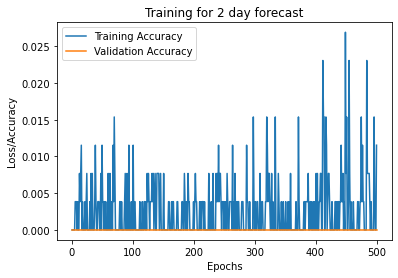

In [73]:
epochs = range(1, len(history2.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history2.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 2 day forecast")
plt.legend()
plt.show()

In [74]:
x = [i for i in range(int(testing_features2[0,-1]+1), int(testing_features2[-1,-1]+2))]
y = testing_labels2
x_pred = testing_features2
y_pred = NN_model.predict(x_pred) 
err2 = np.abs(y - y_pred)
acc2 = np.ones(len(y)) - np.divide(err2, y)
acc_bar2 = np.mean(acc2)
rms2 = np.sqrt(np.mean((err2)**2))
print("Average accuracy:", acc_bar2)
print("RMS:", rms2)

Average accuracy: 0.8284410164537016
RMS: 776065.6631048855


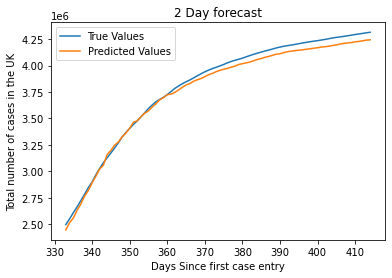

In [31]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("2 Day forecast")
plt.legend()
plt.show()

In [50]:
window_size = 7
forecast = 5
features3, labels3 = create_features(pos_cases_df, window_size, forecast)

In [51]:
training_features3, testing_features3 = np.split(features3, [int(0.8*len(features3))])
training_labels3, testing_labels3 = np.split(labels3, [int(0.8*len(labels3))])

In [52]:
history3 = NN_model.fit(training_features3, training_labels3, epochs=500, validation_split=0.2)

Train on 259 samples, validate on 65 samples
Epoch 1/500
259/259 [==============================] - 0s 121us/step - loss: 110928.1213 - accuracy: 0.0000e+00 - val_loss: 675325.1635 - val_accuracy: 0.0000e+00
Epoch 2/500
259/259 [==============================] - 0s 121us/step - loss: 65943.4317 - accuracy: 0.0000e+00 - val_loss: 194559.0808 - val_accuracy: 0.0000e+00
Epoch 3/500
259/259 [==============================] - 0s 85us/step - loss: 58270.5959 - accuracy: 0.0000e+00 - val_loss: 413003.9288 - val_accuracy: 0.0000e+00
Epoch 4/500
259/259 [==============================] - 0s 121us/step - loss: 38332.1261 - accuracy: 0.0000e+00 - val_loss: 177266.1952 - val_accuracy: 0.0000e+00
Epoch 5/500
259/259 [==============================] - 0s 121us/step - loss: 25770.1786 - accuracy: 0.0000e+00 - val_loss: 259098.7615 - val_accuracy: 0.0000e+00
Epoch 6/500
259/259 [==============================] - 0s 113us/step - loss: 22076.0712 - accuracy: 0.0000e+00 - val_loss: 211843.2615 - val_accu

259/259 [==============================] - 0s 96us/step - loss: 5983.1238 - accuracy: 0.0000e+00 - val_loss: 153781.2038 - val_accuracy: 0.0000e+00
Epoch 103/500
259/259 [==============================] - 0s 96us/step - loss: 2956.7068 - accuracy: 0.0000e+00 - val_loss: 133098.9462 - val_accuracy: 0.0000e+00
Epoch 104/500
259/259 [==============================] - 0s 100us/step - loss: 4392.6239 - accuracy: 0.0000e+00 - val_loss: 155998.3231 - val_accuracy: 0.0000e+00
Epoch 105/500
259/259 [==============================] - 0s 100us/step - loss: 3285.0876 - accuracy: 0.0000e+00 - val_loss: 181243.8615 - val_accuracy: 0.0000e+00
Epoch 106/500
259/259 [==============================] - 0s 100us/step - loss: 3309.6389 - accuracy: 0.0000e+00 - val_loss: 148011.4538 - val_accuracy: 0.0000e+00
Epoch 107/500
259/259 [==============================] - 0s 116us/step - loss: 4027.8945 - accuracy: 0.0000e+00 - val_loss: 170466.5500 - val_accuracy: 0.0000e+00
Epoch 108/500
259/259 [===============

Epoch 153/500
259/259 [==============================] - 0s 60us/step - loss: 3056.0626 - accuracy: 0.0000e+00 - val_loss: 172776.9115 - val_accuracy: 0.0000e+00
Epoch 154/500
259/259 [==============================] - 0s 121us/step - loss: 4052.0601 - accuracy: 0.0000e+00 - val_loss: 146362.7308 - val_accuracy: 0.0000e+00
Epoch 155/500
259/259 [==============================] - 0s 124us/step - loss: 3230.7760 - accuracy: 0.0039 - val_loss: 142197.5788 - val_accuracy: 0.0000e+00
Epoch 156/500
259/259 [==============================] - 0s 96us/step - loss: 2821.0582 - accuracy: 0.0000e+00 - val_loss: 121217.8240 - val_accuracy: 0.0000e+00
Epoch 157/500
259/259 [==============================] - 0s 96us/step - loss: 5729.6541 - accuracy: 0.0039 - val_loss: 132121.0019 - val_accuracy: 0.0000e+00
Epoch 158/500
259/259 [==============================] - 0s 93us/step - loss: 4664.9050 - accuracy: 0.0000e+00 - val_loss: 174765.4769 - val_accuracy: 0.0000e+00
Epoch 159/500
259/259 [===========

Epoch 255/500
259/259 [==============================] - 0s 93us/step - loss: 3213.6657 - accuracy: 0.0077 - val_loss: 136257.4846 - val_accuracy: 0.0000e+00
Epoch 256/500
259/259 [==============================] - 0s 93us/step - loss: 2821.9962 - accuracy: 0.0000e+00 - val_loss: 135190.0769 - val_accuracy: 0.0000e+00
Epoch 257/500
259/259 [==============================] - 0s 93us/step - loss: 2422.5946 - accuracy: 0.0039 - val_loss: 96792.0481 - val_accuracy: 0.0000e+00
Epoch 258/500
259/259 [==============================] - 0s 89us/step - loss: 6066.1571 - accuracy: 0.0077 - val_loss: 93238.5231 - val_accuracy: 0.0000e+00
Epoch 259/500
259/259 [==============================] - 0s 96us/step - loss: 4940.9693 - accuracy: 0.0000e+00 - val_loss: 118720.2538 - val_accuracy: 0.0000e+00
Epoch 260/500
259/259 [==============================] - 0s 89us/step - loss: 2997.3295 - accuracy: 0.0000e+00 - val_loss: 126663.2346 - val_accuracy: 0.0000e+00
Epoch 261/500
259/259 [===================

259/259 [==============================] - 0s 121us/step - loss: 4111.5597 - accuracy: 0.0000e+00 - val_loss: 97403.4663 - val_accuracy: 0.0000e+00
Epoch 358/500
259/259 [==============================] - 0s 121us/step - loss: 2671.7513 - accuracy: 0.0039 - val_loss: 104572.4635 - val_accuracy: 0.0000e+00
Epoch 359/500
259/259 [==============================] - 0s 85us/step - loss: 3173.4006 - accuracy: 0.0000e+00 - val_loss: 106615.0115 - val_accuracy: 0.0000e+00
Epoch 360/500
259/259 [==============================] - 0s 121us/step - loss: 2699.0631 - accuracy: 0.0000e+00 - val_loss: 80056.4673 - val_accuracy: 0.0000e+00
Epoch 361/500
259/259 [==============================] - 0s 121us/step - loss: 5974.7208 - accuracy: 0.0000e+00 - val_loss: 102663.3673 - val_accuracy: 0.0000e+00
Epoch 362/500
259/259 [==============================] - 0s 60us/step - loss: 4432.1365 - accuracy: 0.0000e+00 - val_loss: 101974.0625 - val_accuracy: 0.0000e+00
Epoch 363/500
259/259 [=====================

259/259 [==============================] - 0s 121us/step - loss: 2613.4052 - accuracy: 0.0000e+00 - val_loss: 145772.5269 - val_accuracy: 0.0000e+00
Epoch 460/500
259/259 [==============================] - 0s 104us/step - loss: 3417.0945 - accuracy: 0.0000e+00 - val_loss: 90218.0606 - val_accuracy: 0.0000e+00
Epoch 461/500
259/259 [==============================] - 0s 96us/step - loss: 3894.8658 - accuracy: 0.0039 - val_loss: 138837.3808 - val_accuracy: 0.0000e+00
Epoch 462/500
259/259 [==============================] - 0s 93us/step - loss: 5965.8905 - accuracy: 0.0000e+00 - val_loss: 134856.6712 - val_accuracy: 0.0000e+00
Epoch 463/500
259/259 [==============================] - 0s 104us/step - loss: 6292.8194 - accuracy: 0.0039 - val_loss: 88529.8788 - val_accuracy: 0.0000e+00
Epoch 464/500
259/259 [==============================] - 0s 93us/step - loss: 4100.5750 - accuracy: 0.0039 - val_loss: 123324.5558 - val_accuracy: 0.0000e+00
Epoch 465/500
259/259 [==============================

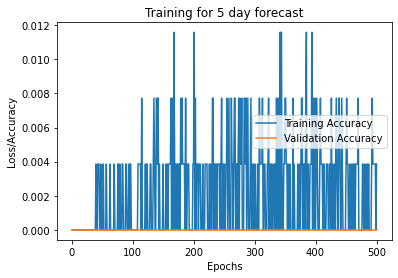

In [54]:
epochs = range(1, len(history3.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history3.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 5 day forecast")
plt.legend()
plt.show()

In [55]:
x = [i for i in range(int(testing_features3[0,-1]+1), int(testing_features3[-1,-1]+2))]
y = testing_labels3
x_pred = testing_features3
y_pred = NN_model.predict(x_pred) 
err3 = np.abs(y - y_pred)
acc3 = np.ones(len(y)) - np.divide(err3, y)
acc_bar3 = np.mean(acc3)
rms3 = np.sqrt(np.mean((err3)**2))
print("Average accuracy:", acc_bar3)
print("RMS:", rms3)

Average accuracy: 0.835666015762657
RMS: 740631.5465441645


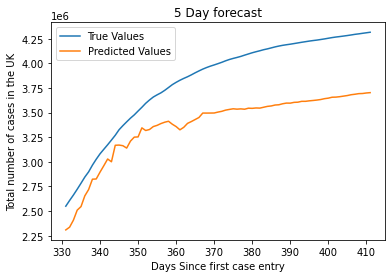

In [60]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("5 Day forecast")
plt.legend()
plt.show()

In [27]:
window_size = 7
forecast = 20
features10, labels10 = create_features(pos_cases_df, window_size, forecast)

In [28]:
training_features10, testing_features10 = np.split(features10, [int(0.8*len(features10))])
training_labels10, testing_labels10 = np.split(labels10, [int(0.8*len(labels10))])

In [29]:
history10 = NN_model.fit(training_features10, training_labels10, epochs=500, validation_split=0.2)

Train on 249 samples, validate on 63 samples
Epoch 1/500
249/249 [==============================] - 0s 104us/step - loss: 102493.1796 - accuracy: 0.0000e+00 - val_loss: 858501.1786 - val_accuracy: 0.0000e+00
Epoch 2/500
249/249 [==============================] - 0s 96us/step - loss: 67365.4001 - accuracy: 0.0000e+00 - val_loss: 274433.2024 - val_accuracy: 0.0000e+00
Epoch 3/500
249/249 [==============================] - 0s 96us/step - loss: 50523.5993 - accuracy: 0.0000e+00 - val_loss: 385688.4593 - val_accuracy: 0.0000e+00
Epoch 4/500
249/249 [==============================] - 0s 112us/step - loss: 37697.9945 - accuracy: 0.0000e+00 - val_loss: 331005.0496 - val_accuracy: 0.0000e+00
Epoch 5/500
249/249 [==============================] - 0s 120us/step - loss: 31596.5735 - accuracy: 0.0000e+00 - val_loss: 182273.4464 - val_accuracy: 0.0000e+00
Epoch 6/500
249/249 [==============================] - 0s 108us/step - loss: 29056.3405 - accuracy: 0.0000e+00 - val_loss: 189022.8621 - val_accur

249/249 [==============================] - 0s 96us/step - loss: 12170.0735 - accuracy: 0.0040 - val_loss: 278891.3051 - val_accuracy: 0.0000e+00
Epoch 52/500
249/249 [==============================] - 0s 92us/step - loss: 12579.0062 - accuracy: 0.0000e+00 - val_loss: 275159.3442 - val_accuracy: 0.0000e+00
Epoch 53/500
249/249 [==============================] - 0s 92us/step - loss: 13134.7344 - accuracy: 0.0000e+00 - val_loss: 273436.2609 - val_accuracy: 0.0000e+00
Epoch 54/500
249/249 [==============================] - 0s 92us/step - loss: 12971.2221 - accuracy: 0.0000e+00 - val_loss: 311854.5471 - val_accuracy: 0.0000e+00
Epoch 55/500
249/249 [==============================] - 0s 96us/step - loss: 12606.3846 - accuracy: 0.0000e+00 - val_loss: 296800.8487 - val_accuracy: 0.0000e+00
Epoch 56/500
249/249 [==============================] - 0s 92us/step - loss: 13393.8062 - accuracy: 0.0000e+00 - val_loss: 311191.9048 - val_accuracy: 0.0000e+00
Epoch 57/500
249/249 [=======================

249/249 [==============================] - 0s 104us/step - loss: 10729.7411 - accuracy: 0.0000e+00 - val_loss: 313220.8105 - val_accuracy: 0.0000e+00
Epoch 102/500
249/249 [==============================] - 0s 96us/step - loss: 10268.4303 - accuracy: 0.0000e+00 - val_loss: 336551.7693 - val_accuracy: 0.0000e+00
Epoch 103/500
249/249 [==============================] - 0s 96us/step - loss: 9742.6553 - accuracy: 0.0000e+00 - val_loss: 317356.6518 - val_accuracy: 0.0000e+00
Epoch 104/500
249/249 [==============================] - 0s 100us/step - loss: 10907.2417 - accuracy: 0.0000e+00 - val_loss: 370790.5456 - val_accuracy: 0.0000e+00
Epoch 105/500
249/249 [==============================] - 0s 96us/step - loss: 10953.4670 - accuracy: 0.0000e+00 - val_loss: 345494.4732 - val_accuracy: 0.0000e+00
Epoch 106/500
249/249 [==============================] - 0s 104us/step - loss: 10623.3896 - accuracy: 0.0000e+00 - val_loss: 290320.5526 - val_accuracy: 0.0000e+00
Epoch 107/500
249/249 [===========

Epoch 151/500
249/249 [==============================] - 0s 104us/step - loss: 9906.2509 - accuracy: 0.0040 - val_loss: 357551.0124 - val_accuracy: 0.0000e+00
Epoch 152/500
249/249 [==============================] - 0s 104us/step - loss: 9386.2592 - accuracy: 0.0000e+00 - val_loss: 344925.4772 - val_accuracy: 0.0000e+00
Epoch 153/500
249/249 [==============================] - 0s 104us/step - loss: 9550.5107 - accuracy: 0.0000e+00 - val_loss: 391266.0164 - val_accuracy: 0.0000e+00
Epoch 154/500
249/249 [==============================] - 0s 100us/step - loss: 9886.4676 - accuracy: 0.0000e+00 - val_loss: 306160.8601 - val_accuracy: 0.0000e+00
Epoch 155/500
249/249 [==============================] - 0s 100us/step - loss: 12853.7129 - accuracy: 0.0000e+00 - val_loss: 338343.5997 - val_accuracy: 0.0000e+00
Epoch 156/500
249/249 [==============================] - 0s 92us/step - loss: 13735.7404 - accuracy: 0.0000e+00 - val_loss: 305403.0625 - val_accuracy: 0.0000e+00
Epoch 157/500
249/249 [==

249/249 [==============================] - 0s 100us/step - loss: 9348.1364 - accuracy: 0.0000e+00 - val_loss: 399656.5923 - val_accuracy: 0.0000e+00
Epoch 202/500
249/249 [==============================] - 0s 100us/step - loss: 8490.4296 - accuracy: 0.0000e+00 - val_loss: 398803.3750 - val_accuracy: 0.0000e+00
Epoch 203/500
249/249 [==============================] - 0s 92us/step - loss: 8858.6722 - accuracy: 0.0000e+00 - val_loss: 351117.6310 - val_accuracy: 0.0000e+00
Epoch 204/500
249/249 [==============================] - 0s 100us/step - loss: 10604.5884 - accuracy: 0.0000e+00 - val_loss: 393836.1121 - val_accuracy: 0.0000e+00
Epoch 205/500
249/249 [==============================] - 0s 96us/step - loss: 9183.7027 - accuracy: 0.0000e+00 - val_loss: 426425.8492 - val_accuracy: 0.0000e+00
Epoch 206/500
249/249 [==============================] - 0s 100us/step - loss: 11025.8963 - accuracy: 0.0000e+00 - val_loss: 352987.7143 - val_accuracy: 0.0000e+00
Epoch 207/500
249/249 [=============

249/249 [==============================] - 0s 100us/step - loss: 6807.3658 - accuracy: 0.0000e+00 - val_loss: 419147.4216 - val_accuracy: 0.0000e+00
Epoch 252/500
249/249 [==============================] - 0s 104us/step - loss: 7055.7248 - accuracy: 0.0000e+00 - val_loss: 408067.5595 - val_accuracy: 0.0000e+00
Epoch 253/500
249/249 [==============================] - 0s 92us/step - loss: 7731.2303 - accuracy: 0.0000e+00 - val_loss: 425519.1696 - val_accuracy: 0.0000e+00
Epoch 254/500
249/249 [==============================] - 0s 92us/step - loss: 7329.4878 - accuracy: 0.0000e+00 - val_loss: 428467.5784 - val_accuracy: 0.0000e+00
Epoch 255/500
249/249 [==============================] - 0s 88us/step - loss: 6933.5368 - accuracy: 0.0000e+00 - val_loss: 415196.1696 - val_accuracy: 0.0000e+00
Epoch 256/500
249/249 [==============================] - 0s 92us/step - loss: 7388.1221 - accuracy: 0.0000e+00 - val_loss: 420515.3413 - val_accuracy: 0.0000e+00
Epoch 257/500
249/249 [=================

249/249 [==============================] - 0s 92us/step - loss: 6766.8296 - accuracy: 0.0000e+00 - val_loss: 419471.3849 - val_accuracy: 0.0000e+00
Epoch 302/500
249/249 [==============================] - 0s 100us/step - loss: 6648.4850 - accuracy: 0.0000e+00 - val_loss: 454732.0615 - val_accuracy: 0.0000e+00
Epoch 303/500
249/249 [==============================] - 0s 92us/step - loss: 7320.6459 - accuracy: 0.0000e+00 - val_loss: 400293.4772 - val_accuracy: 0.0000e+00
Epoch 304/500
249/249 [==============================] - 0s 100us/step - loss: 7922.4871 - accuracy: 0.0000e+00 - val_loss: 420630.4444 - val_accuracy: 0.0000e+00
Epoch 305/500
249/249 [==============================] - 0s 96us/step - loss: 6642.3291 - accuracy: 0.0000e+00 - val_loss: 461410.7163 - val_accuracy: 0.0000e+00
Epoch 306/500
249/249 [==============================] - 0s 88us/step - loss: 7755.9625 - accuracy: 0.0000e+00 - val_loss: 404162.0198 - val_accuracy: 0.0000e+00
Epoch 307/500
249/249 [=================

249/249 [==============================] - 0s 92us/step - loss: 6830.3847 - accuracy: 0.0000e+00 - val_loss: 453155.2520 - val_accuracy: 0.0000e+00
Epoch 352/500
249/249 [==============================] - 0s 92us/step - loss: 7640.3005 - accuracy: 0.0000e+00 - val_loss: 440521.1319 - val_accuracy: 0.0000e+00
Epoch 353/500
249/249 [==============================] - 0s 92us/step - loss: 8941.8840 - accuracy: 0.0000e+00 - val_loss: 450923.1022 - val_accuracy: 0.0000e+00
Epoch 354/500
249/249 [==============================] - 0s 92us/step - loss: 7991.9031 - accuracy: 0.0000e+00 - val_loss: 417371.7976 - val_accuracy: 0.0000e+00
Epoch 355/500
249/249 [==============================] - 0s 92us/step - loss: 9133.5622 - accuracy: 0.0000e+00 - val_loss: 514351.2619 - val_accuracy: 0.0000e+00
Epoch 356/500
249/249 [==============================] - 0s 92us/step - loss: 9482.4848 - accuracy: 0.0000e+00 - val_loss: 451394.2589 - val_accuracy: 0.0000e+00
Epoch 357/500
249/249 [===================

249/249 [==============================] - 0s 108us/step - loss: 5376.4797 - accuracy: 0.0000e+00 - val_loss: 437782.1250 - val_accuracy: 0.0000e+00
Epoch 402/500
249/249 [==============================] - 0s 104us/step - loss: 7202.2795 - accuracy: 0.0000e+00 - val_loss: 465515.2996 - val_accuracy: 0.0000e+00
Epoch 403/500
249/249 [==============================] - 0s 112us/step - loss: 5421.7838 - accuracy: 0.0000e+00 - val_loss: 442184.9931 - val_accuracy: 0.0000e+00
Epoch 404/500
249/249 [==============================] - 0s 261us/step - loss: 5684.5699 - accuracy: 0.0000e+00 - val_loss: 452370.1290 - val_accuracy: 0.0000e+00
Epoch 405/500
249/249 [==============================] - 0s 124us/step - loss: 8275.7957 - accuracy: 0.0000e+00 - val_loss: 456779.3899 - val_accuracy: 0.0000e+00
Epoch 406/500
249/249 [==============================] - 0s 92us/step - loss: 8584.8170 - accuracy: 0.0000e+00 - val_loss: 443303.7272 - val_accuracy: 0.0000e+00
Epoch 407/500
249/249 [==============

249/249 [==============================] - 0s 92us/step - loss: 4640.2634 - accuracy: 0.0040 - val_loss: 445610.2738 - val_accuracy: 0.0000e+00
Epoch 452/500
249/249 [==============================] - 0s 96us/step - loss: 4651.3778 - accuracy: 0.0000e+00 - val_loss: 451882.6607 - val_accuracy: 0.0000e+00
Epoch 453/500
249/249 [==============================] - 0s 92us/step - loss: 4552.4051 - accuracy: 0.0000e+00 - val_loss: 472955.9306 - val_accuracy: 0.0000e+00
Epoch 454/500
249/249 [==============================] - 0s 96us/step - loss: 7418.9832 - accuracy: 0.0000e+00 - val_loss: 421697.8413 - val_accuracy: 0.0000e+00
Epoch 455/500
249/249 [==============================] - 0s 88us/step - loss: 7339.8242 - accuracy: 0.0000e+00 - val_loss: 464995.7827 - val_accuracy: 0.0000e+00
Epoch 456/500
249/249 [==============================] - 0s 96us/step - loss: 5870.4850 - accuracy: 0.0000e+00 - val_loss: 414149.3571 - val_accuracy: 0.0000e+00
Epoch 457/500
249/249 [=======================

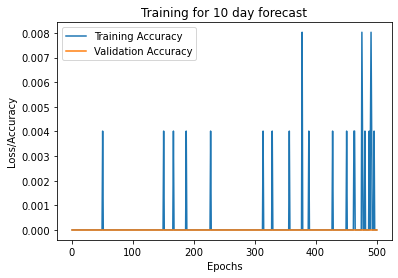

In [30]:
epochs = range(1, len(history10.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history10.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history10.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 10 day forecast")
plt.legend()
plt.show()

In [31]:
x = [i for i in range(int(testing_features10[0,-1]+1), int(testing_features10[-1,-1]+2))]
y = testing_labels10
x_pred = testing_features10
y_pred = NN_model.predict(x_pred) 
err10 = np.abs(y - y_pred)
acc10 = np.ones(len(y)) - np.divide(err10, y)
acc_bar10 = np.mean(acc10)
rms10 = np.sqrt(np.mean((err10)**2))
print("Average accuracy:", acc_bar10)
print("RMS:", rms10)

Average accuracy: 0.7132439509792132
RMS: 1278198.0743868807


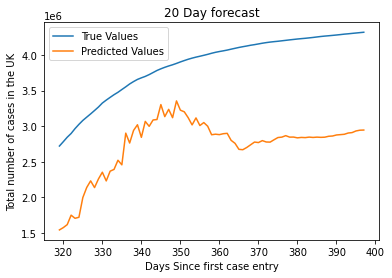

In [32]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("20 Day forecast")
plt.legend()
plt.show()

In [22]:
window_size = 7
forecast = 50
features50, labels50 = create_features(pos_cases_df, window_size, forecast)

In [23]:
training_features50, testing_features50 = np.split(features50, [int(0.8*len(features50))])
training_labels50, testing_labels50 = np.split(labels50, [int(0.8*len(labels50))])

In [24]:
history50 = NN_model.fit(training_features50, training_labels50, epochs=500, validation_split=0.2)

Train on 230 samples, validate on 58 samples
Epoch 1/500
230/230 [==============================] - 0s 1ms/step - loss: 369879.0951 - accuracy: 0.0000e+00 - val_loss: 1934043.0172 - val_accuracy: 0.0000e+00
Epoch 2/500
230/230 [==============================] - 0s 104us/step - loss: 361101.4944 - accuracy: 0.0000e+00 - val_loss: 1763430.8534 - val_accuracy: 0.0000e+00
Epoch 3/500
230/230 [==============================] - 0s 104us/step - loss: 300112.0610 - accuracy: 0.0000e+00 - val_loss: 818683.0366 - val_accuracy: 0.0000e+00
Epoch 4/500
230/230 [==============================] - 0s 117us/step - loss: 155470.5944 - accuracy: 0.0000e+00 - val_loss: 802333.8922 - val_accuracy: 0.0000e+00
Epoch 5/500
230/230 [==============================] - 0s 113us/step - loss: 150435.7466 - accuracy: 0.0000e+00 - val_loss: 518532.9009 - val_accuracy: 0.0000e+00
Epoch 6/500
230/230 [==============================] - 0s 109us/step - loss: 127746.3135 - accuracy: 0.0000e+00 - val_loss: 299782.2031 - va

Epoch 51/500
230/230 [==============================] - 0s 113us/step - loss: 78956.5085 - accuracy: 0.0000e+00 - val_loss: 652617.4246 - val_accuracy: 0.0000e+00
Epoch 52/500
230/230 [==============================] - 0s 100us/step - loss: 73558.5298 - accuracy: 0.0000e+00 - val_loss: 658974.5043 - val_accuracy: 0.0000e+00
Epoch 53/500
230/230 [==============================] - 0s 116us/step - loss: 69821.3052 - accuracy: 0.0000e+00 - val_loss: 587641.8362 - val_accuracy: 0.0000e+00
Epoch 54/500
230/230 [==============================] - 0s 109us/step - loss: 75007.4147 - accuracy: 0.0000e+00 - val_loss: 383416.5733 - val_accuracy: 0.0000e+00
Epoch 55/500
230/230 [==============================] - 0s 109us/step - loss: 77906.8648 - accuracy: 0.0000e+00 - val_loss: 790651.8147 - val_accuracy: 0.0000e+00
Epoch 56/500
230/230 [==============================] - 0s 104us/step - loss: 68609.8854 - accuracy: 0.0000e+00 - val_loss: 514887.8664 - val_accuracy: 0.0000e+00
Epoch 57/500
230/230 [

230/230 [==============================] - 0s 109us/step - loss: 38108.7033 - accuracy: 0.0000e+00 - val_loss: 609438.9720 - val_accuracy: 0.0000e+00
Epoch 102/500
230/230 [==============================] - 0s 109us/step - loss: 43321.2732 - accuracy: 0.0000e+00 - val_loss: 751802.6918 - val_accuracy: 0.0000e+00
Epoch 103/500
230/230 [==============================] - 0s 104us/step - loss: 39961.9300 - accuracy: 0.0000e+00 - val_loss: 684592.6832 - val_accuracy: 0.0000e+00
Epoch 104/500
230/230 [==============================] - 0s 113us/step - loss: 43892.1342 - accuracy: 0.0000e+00 - val_loss: 816331.2457 - val_accuracy: 0.0000e+00
Epoch 105/500
230/230 [==============================] - 0s 113us/step - loss: 48295.1857 - accuracy: 0.0000e+00 - val_loss: 905080.4138 - val_accuracy: 0.0000e+00
Epoch 106/500
230/230 [==============================] - 0s 109us/step - loss: 50833.7138 - accuracy: 0.0000e+00 - val_loss: 789498.9914 - val_accuracy: 0.0000e+00
Epoch 107/500
230/230 [=======

230/230 [==============================] - 0s 101us/step - loss: 29911.7785 - accuracy: 0.0000e+00 - val_loss: 817713.4892 - val_accuracy: 0.0000e+00
Epoch 152/500
230/230 [==============================] - 0s 109us/step - loss: 31253.5854 - accuracy: 0.0000e+00 - val_loss: 874221.2241 - val_accuracy: 0.0000e+00
Epoch 153/500
230/230 [==============================] - 0s 113us/step - loss: 28685.5130 - accuracy: 0.0000e+00 - val_loss: 882364.1638 - val_accuracy: 0.0000e+00
Epoch 154/500
230/230 [==============================] - 0s 100us/step - loss: 38361.1520 - accuracy: 0.0000e+00 - val_loss: 865361.9181 - val_accuracy: 0.0000e+00
Epoch 155/500
230/230 [==============================] - 0s 104us/step - loss: 30844.1844 - accuracy: 0.0000e+00 - val_loss: 925570.5000 - val_accuracy: 0.0000e+00
Epoch 156/500
230/230 [==============================] - 0s 109us/step - loss: 31426.5550 - accuracy: 0.0000e+00 - val_loss: 856737.2198 - val_accuracy: 0.0000e+00
Epoch 157/500
230/230 [=======

230/230 [==============================] - 0s 104us/step - loss: 24113.8462 - accuracy: 0.0000e+00 - val_loss: 830963.6336 - val_accuracy: 0.0000e+00
Epoch 202/500
230/230 [==============================] - 0s 109us/step - loss: 36656.2992 - accuracy: 0.0000e+00 - val_loss: 818479.6509 - val_accuracy: 0.0000e+00
Epoch 203/500
230/230 [==============================] - 0s 104us/step - loss: 26971.8718 - accuracy: 0.0000e+00 - val_loss: 838656.6810 - val_accuracy: 0.0000e+00
Epoch 204/500
230/230 [==============================] - 0s 109us/step - loss: 26138.5861 - accuracy: 0.0000e+00 - val_loss: 867418.8922 - val_accuracy: 0.0000e+00
Epoch 205/500
230/230 [==============================] - 0s 100us/step - loss: 30421.1388 - accuracy: 0.0000e+00 - val_loss: 863051.1983 - val_accuracy: 0.0000e+00
Epoch 206/500
230/230 [==============================] - 0s 100us/step - loss: 25318.0432 - accuracy: 0.0000e+00 - val_loss: 893151.1509 - val_accuracy: 0.0000e+00
Epoch 207/500
230/230 [=======

230/230 [==============================] - 0s 104us/step - loss: 20842.9378 - accuracy: 0.0000e+00 - val_loss: 924735.1638 - val_accuracy: 0.0000e+00
Epoch 252/500
230/230 [==============================] - 0s 108us/step - loss: 27270.6018 - accuracy: 0.0000e+00 - val_loss: 962677.2069 - val_accuracy: 0.0000e+00
Epoch 253/500
230/230 [==============================] - 0s 104us/step - loss: 30323.2763 - accuracy: 0.0000e+00 - val_loss: 951657.6379 - val_accuracy: 0.0000e+00
Epoch 254/500
230/230 [==============================] - 0s 113us/step - loss: 22857.1813 - accuracy: 0.0000e+00 - val_loss: 882616.2974 - val_accuracy: 0.0000e+00
Epoch 255/500
230/230 [==============================] - 0s 113us/step - loss: 27578.1745 - accuracy: 0.0000e+00 - val_loss: 792652.0905 - val_accuracy: 0.0000e+00
Epoch 256/500
230/230 [==============================] - 0s 100us/step - loss: 31738.9479 - accuracy: 0.0000e+00 - val_loss: 934131.9224 - val_accuracy: 0.0000e+00
Epoch 257/500
230/230 [=======

230/230 [==============================] - 0s 104us/step - loss: 17700.2602 - accuracy: 0.0000e+00 - val_loss: 958893.4267 - val_accuracy: 0.0000e+00
Epoch 302/500
230/230 [==============================] - 0s 109us/step - loss: 19377.3636 - accuracy: 0.0000e+00 - val_loss: 868526.5345 - val_accuracy: 0.0000e+00
Epoch 303/500
230/230 [==============================] - 0s 100us/step - loss: 18708.8302 - accuracy: 0.0000e+00 - val_loss: 875160.7500 - val_accuracy: 0.0000e+00
Epoch 304/500
230/230 [==============================] - 0s 109us/step - loss: 17670.5278 - accuracy: 0.0000e+00 - val_loss: 932054.5431 - val_accuracy: 0.0000e+00
Epoch 305/500
230/230 [==============================] - 0s 100us/step - loss: 21878.0767 - accuracy: 0.0000e+00 - val_loss: 958745.7543 - val_accuracy: 0.0000e+00
Epoch 306/500
230/230 [==============================] - 0s 100us/step - loss: 21470.1644 - accuracy: 0.0000e+00 - val_loss: 884895.2414 - val_accuracy: 0.0000e+00
Epoch 307/500
230/230 [=======

230/230 [==============================] - 0s 109us/step - loss: 24286.5493 - accuracy: 0.0000e+00 - val_loss: 880375.5431 - val_accuracy: 0.0000e+00
Epoch 352/500
230/230 [==============================] - 0s 100us/step - loss: 18789.2687 - accuracy: 0.0000e+00 - val_loss: 974784.6681 - val_accuracy: 0.0000e+00
Epoch 353/500
230/230 [==============================] - 0s 100us/step - loss: 22520.1720 - accuracy: 0.0000e+00 - val_loss: 915283.6466 - val_accuracy: 0.0000e+00
Epoch 354/500
230/230 [==============================] - 0s 109us/step - loss: 20557.8507 - accuracy: 0.0000e+00 - val_loss: 899793.6638 - val_accuracy: 0.0000e+00
Epoch 355/500
230/230 [==============================] - 0s 96us/step - loss: 16674.9661 - accuracy: 0.0000e+00 - val_loss: 873341.9138 - val_accuracy: 0.0000e+00
Epoch 356/500
230/230 [==============================] - 0s 100us/step - loss: 20073.2127 - accuracy: 0.0000e+00 - val_loss: 938439.8491 - val_accuracy: 0.0000e+00
Epoch 357/500
230/230 [========

230/230 [==============================] - 0s 109us/step - loss: 13100.0589 - accuracy: 0.0000e+00 - val_loss: 876691.1552 - val_accuracy: 0.0000e+00
Epoch 402/500
230/230 [==============================] - 0s 100us/step - loss: 14123.0671 - accuracy: 0.0000e+00 - val_loss: 835121.4741 - val_accuracy: 0.0000e+00
Epoch 403/500
230/230 [==============================] - 0s 100us/step - loss: 20985.6060 - accuracy: 0.0000e+00 - val_loss: 845813.7155 - val_accuracy: 0.0000e+00
Epoch 404/500
230/230 [==============================] - 0s 100us/step - loss: 16059.6119 - accuracy: 0.0000e+00 - val_loss: 880076.3233 - val_accuracy: 0.0000e+00
Epoch 405/500
230/230 [==============================] - 0s 104us/step - loss: 13845.3751 - accuracy: 0.0000e+00 - val_loss: 904281.1293 - val_accuracy: 0.0000e+00
Epoch 406/500
230/230 [==============================] - 0s 96us/step - loss: 13589.4119 - accuracy: 0.0000e+00 - val_loss: 882852.4052 - val_accuracy: 0.0000e+00
Epoch 407/500
230/230 [========

230/230 [==============================] - 0s 100us/step - loss: 18596.6539 - accuracy: 0.0000e+00 - val_loss: 934744.7759 - val_accuracy: 0.0000e+00
Epoch 452/500
230/230 [==============================] - 0s 104us/step - loss: 14465.5803 - accuracy: 0.0000e+00 - val_loss: 887134.2974 - val_accuracy: 0.0000e+00
Epoch 453/500
230/230 [==============================] - 0s 104us/step - loss: 13613.2937 - accuracy: 0.0000e+00 - val_loss: 889437.1078 - val_accuracy: 0.0000e+00
Epoch 454/500
230/230 [==============================] - 0s 113us/step - loss: 17977.5689 - accuracy: 0.0000e+00 - val_loss: 892208.6164 - val_accuracy: 0.0000e+00
Epoch 455/500
230/230 [==============================] - 0s 100us/step - loss: 17575.9197 - accuracy: 0.0000e+00 - val_loss: 817540.4698 - val_accuracy: 0.0000e+00
Epoch 456/500
230/230 [==============================] - 0s 102us/step - loss: 21092.6983 - accuracy: 0.0000e+00 - val_loss: 872133.5043 - val_accuracy: 0.0000e+00
Epoch 457/500
230/230 [=======

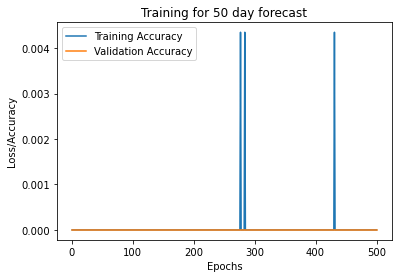

In [26]:
epochs = range(1, len(history50.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history50.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training for 50 day forecast")
plt.legend()
plt.show()

In [48]:
x = [i for i in range(int(testing_features50[0,-1]+1), int(testing_features50[-1,-1]+2))]
y = testing_labels50
x_pred = testing_features50
y_pred = NN_model.predict(x_pred) 
err50 = np.abs(y - y_pred)
acc50 = np.ones(len(y)) - np.divide(err50, y)
acc_bar50 = np.mean(acc50)
rms50 = np.sqrt(np.mean((err50)**2))
print("Average accuracy:", acc_bar50)
print("RMS:", rms50)

Average accuracy: 0.6372908913119955
RMS: 1677559.618808206


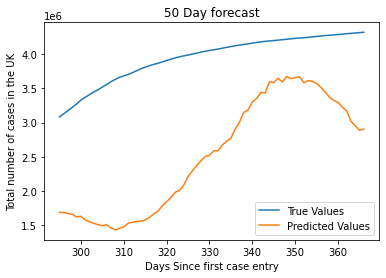

In [49]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("50 Day forecast")
plt.legend()
plt.show()